In [18]:
import pickle
import numpy as np
import pandas as pd
from keras import models
from keras.layers import Dense, Concatenate, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
import time
import os
import sys
import CNN_functions as CNNFuncs

In [19]:
model_mode = "depmap"
model_name = "2"

In [20]:
model = models.load_model("models/{0}/{1}/model.h5".format(model_mode, model_name))
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_218 (Dense)           (None, 200)               80200     
                                                                 
 dense_219 (Dense)           (None, 100)               20100     
                                                                 
 dense_220 (Dense)           (None, 50)                5050      
                                                                 
 dense_221 (Dense)           (None, 500)               25500     
                                                                 
 dense_222 (Dense)           (None, 500)               250500    
                                                                 
 dense_223 (Dense)           (None, 500)               250500    
                                                                 
 dense_224 (Dense)           (None, 500)             

In [21]:
model_info = dict(pd.read_csv("models/{0}/{1}/model_info.csv".format(model_mode, model_name)).to_numpy())

test_size = float(model_info["test_size"])
random_state = int(model_info["random_state"])
model_mode = model_info["model_mode"]
extract_genes_no = int(model_info["extract_genes_no"])
extract_neg_selec = True if model_info["extract_neg_selec"] == "True" else False
filter_labels = model_info["filter_labels"]
l2_reg = float(model_info["l2_reg"])
num_epoch = float(model_info["num_epoch"])

In [22]:
model_datasets, tRCC_datasets, essential_genes = CNNFuncs.preprocess_data(test_size=test_size,
                                                                          random_state=random_state,
                                                                          mode=model_mode,
                                                                          extract_top_genes=extract_genes_no,
                                                                          extract_neg_selec=extract_neg_selec)

X_train = model_datasets[0]
Y_train = model_datasets[2]

X_test = model_datasets[1]
Y_test = model_datasets[3]

tRCC_gene_exp = tRCC_datasets[0]
tRCC_gene_effect = tRCC_datasets[1]

top100_essential_genes = essential_genes["top100_essential_genes"]
top_common_essential_genes = essential_genes["common_essential_genes"]

if filter_labels == "top100_essential_genes":
    Y_train = Y_train[top100_essential_genes]
    Y_test = Y_test[top100_essential_genes]
    tRCC_gene_effect = tRCC_gene_effect[top100_essential_genes]

elif filter_labels == "top_common_essential_genes":
    Y_train = Y_train[top_common_essential_genes]
    Y_test = Y_test[top_common_essential_genes]
    tRCC_gene_effect = tRCC_gene_effect[top_common_essential_genes]

DepMap dataset row/column check:  {'all_match': True, 'column_differences': [[], []], 'row_differences': [[], []]}
tRCC dataset row/column check:  {'all_match': True, 'column_differences': [[], []], 'row_differences': [[], []]}
Check columns across DepMap and tRCC dataframes:  {'all_match': True, 'column_differences': [[], [], [], []]}


In [23]:
training_predictions = pd.DataFrame(model.predict(X_train), columns=Y_train.columns, index=Y_train.index)

26/26 [==============================] - 0s 1ms/step


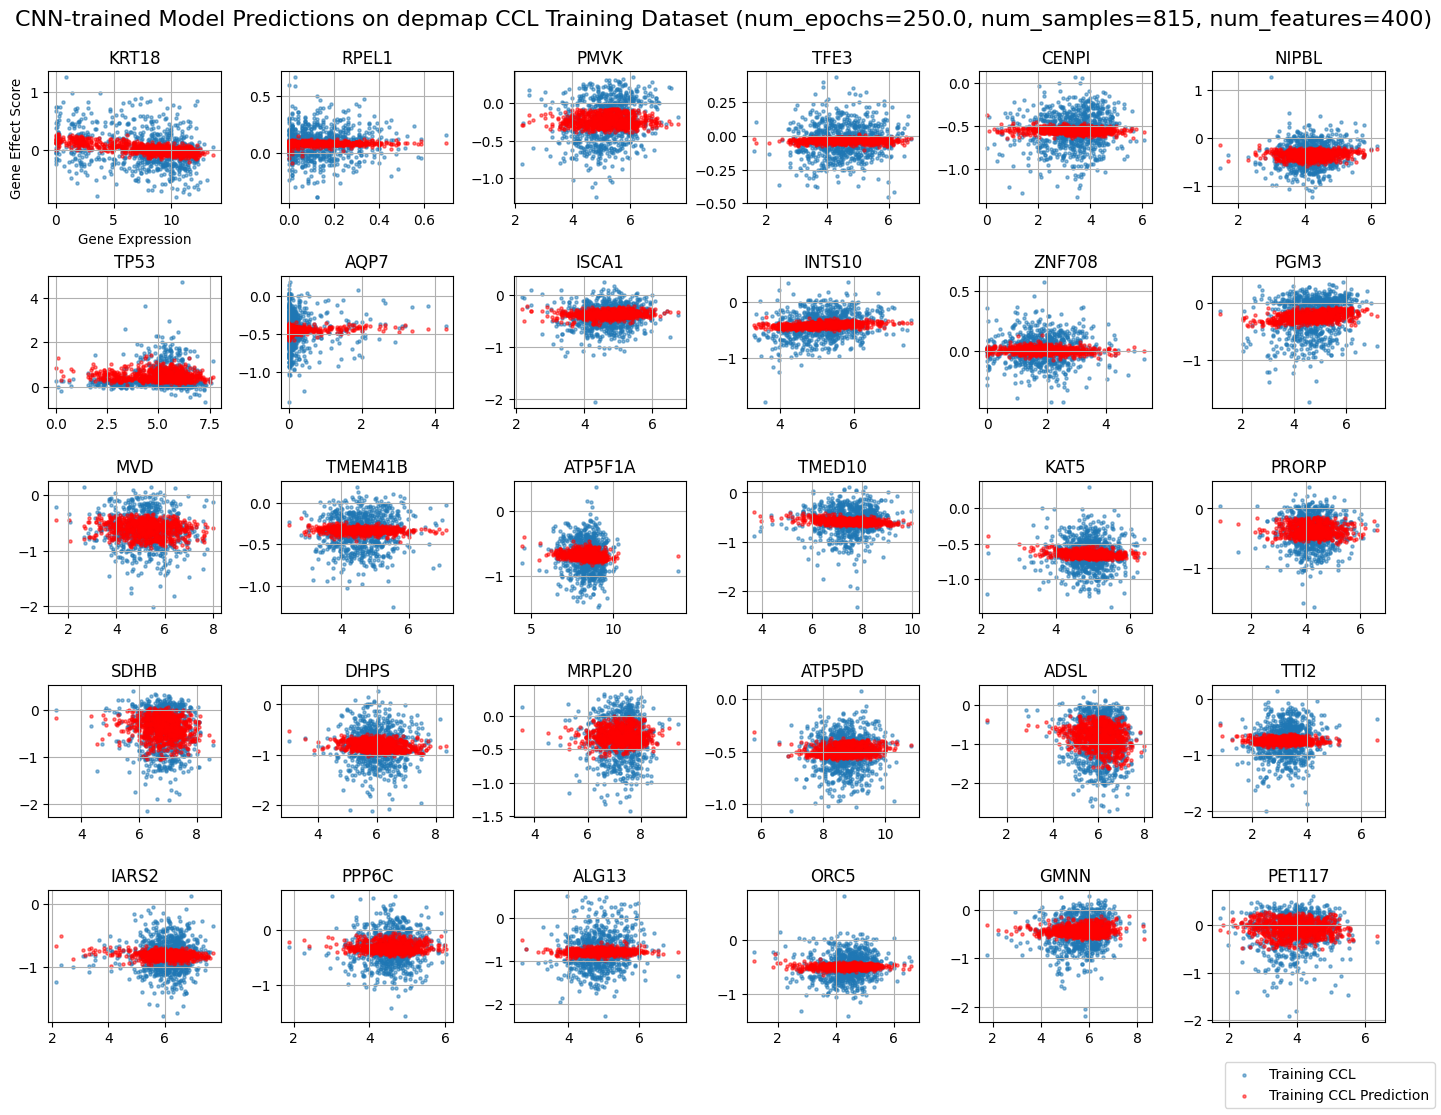

In [24]:
CNNFuncs.GeneRelMiniPlot(X_train, Y_train, top100_essential_genes[:30].to_list(),
                         rel2_X=X_train,
                         rel2_Y=training_predictions,
                         main_title="CNN-trained Model Predictions on {0} CCL Training Dataset (num_epochs={1}, num_samples={3}, num_features={2})".format(model_mode, num_epoch, X_train.shape[1], X_train.shape[0]),
                         axes_labels=["Gene Expression", "Gene Effect Score"],
                         axis_label_fontsize=9.75,
                         legend_titles={"rel1": "Training CCL", "rel2": "Training CCL Prediction"},
                                        sizeProps=[0.925, 0.08, 0.99, 0],
                                        wspace=0.35,
                                        hspace=0.55)

In [25]:
test_predictions = pd.DataFrame(model.predict(X_test), columns=Y_test.columns, index=Y_test.index)

7/7 [==============================] - 0s 1ms/step


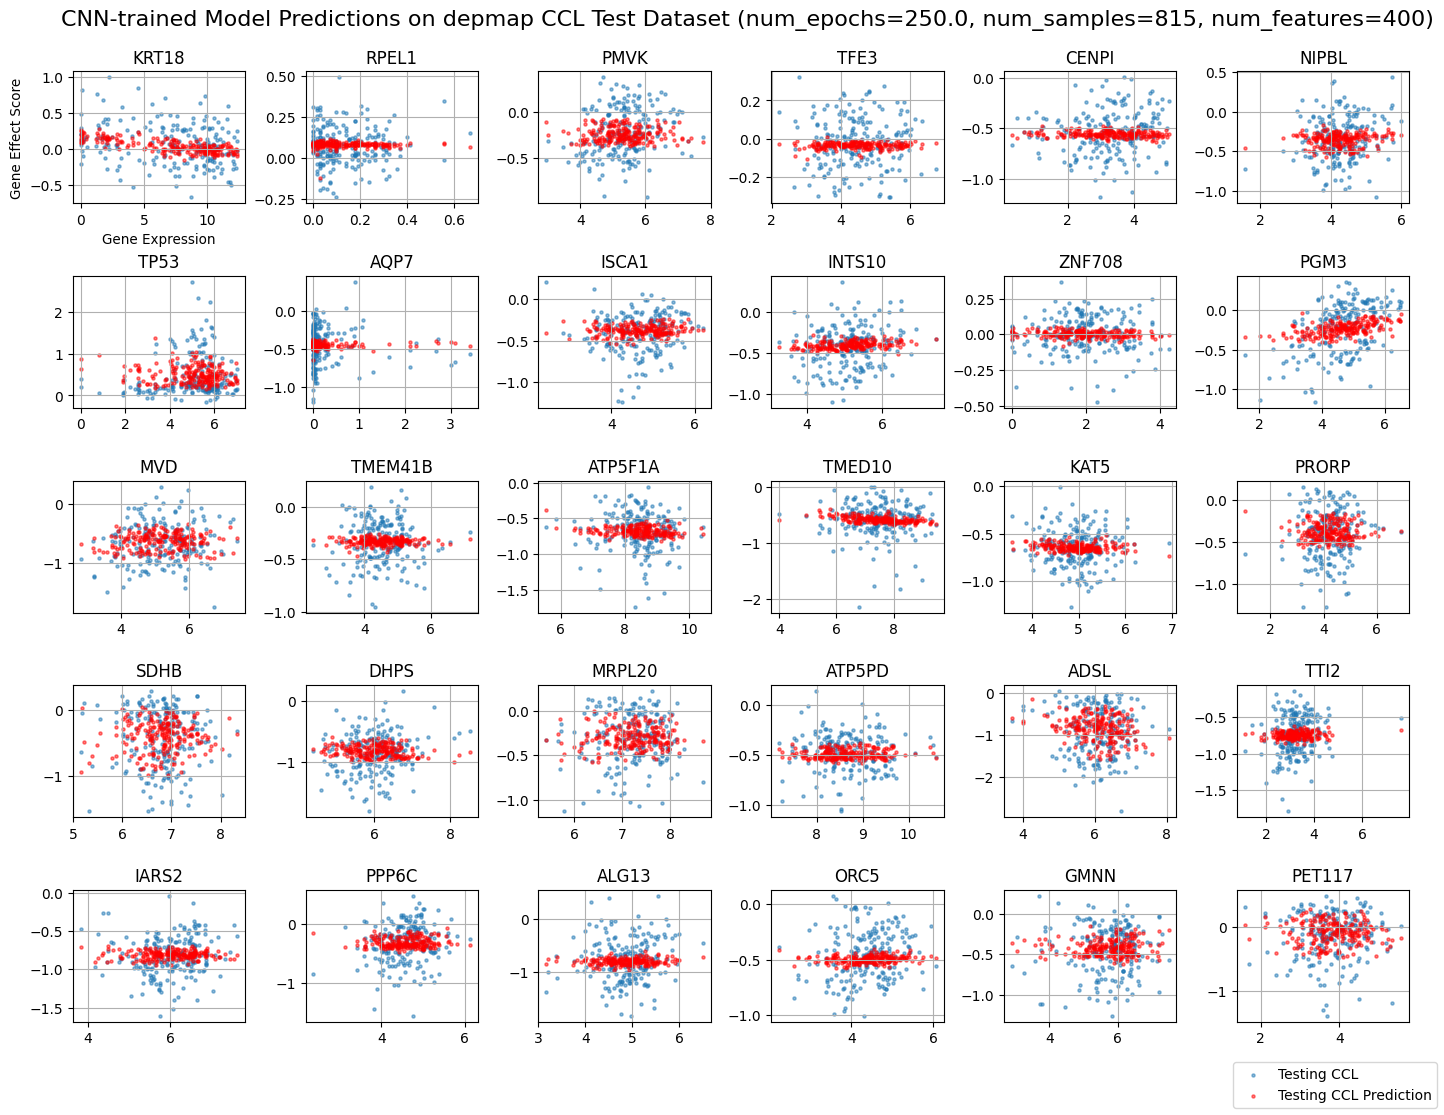

In [26]:
CNNFuncs.GeneRelMiniPlot(X_test, Y_test, top100_essential_genes[:30].to_list(),
                         rel2_X=X_test,
                         rel2_Y=test_predictions,
                         main_title="CNN-trained Model Predictions on {0} CCL Test Dataset (num_epochs={1}, num_samples={3}, num_features={2})".format(model_mode, num_epoch, X_train.shape[1], X_train.shape[0]),
                         axes_labels=["Gene Expression", "Gene Effect Score"],
                         axis_label_fontsize=9.75,
                         legend_titles={"rel1": "Testing CCL", "rel2": "Testing CCL Prediction"},
                                        sizeProps=[0.925, 0.08, 0.99, 0],
                                        wspace=0.35,
                                        hspace=0.55)

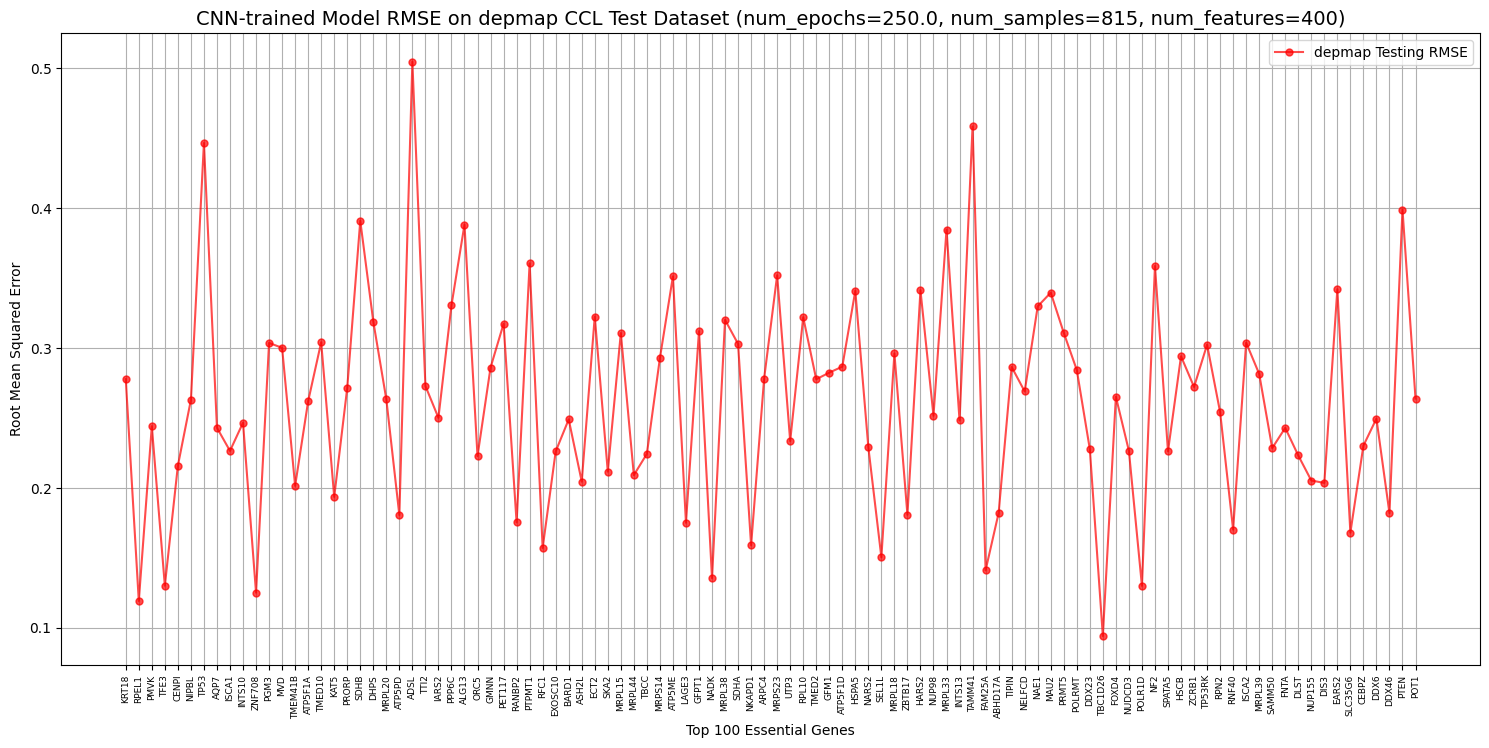

Average RMSE for predicted gene effect scores on testing subset of CCLs: 0.2619


In [27]:
pred_RMSE = CNNFuncs.PredGeneRMSE(Y_test, test_predictions, top100_essential_genes)

CNNFuncs.LinePlot(pred_RMSE, 
            {"RMSE": "red"}, 
            axes_labels=["Top 100 Essential Genes", 
                         "Root Mean Squared Error"], 
            main_title="CNN-trained Model RMSE on {0} CCL Test Dataset (num_epochs={1}, num_samples={3}, num_features={2})".format(model_mode, num_epoch, X_train.shape[1], X_train.shape[0]),
            legend_titles={"RMSE": "{0} Testing RMSE".format(model_mode)})

print("Average RMSE for predicted gene effect scores on testing subset of CCLs: {0:.4}".format(pred_RMSE["RMSE"].mean()))

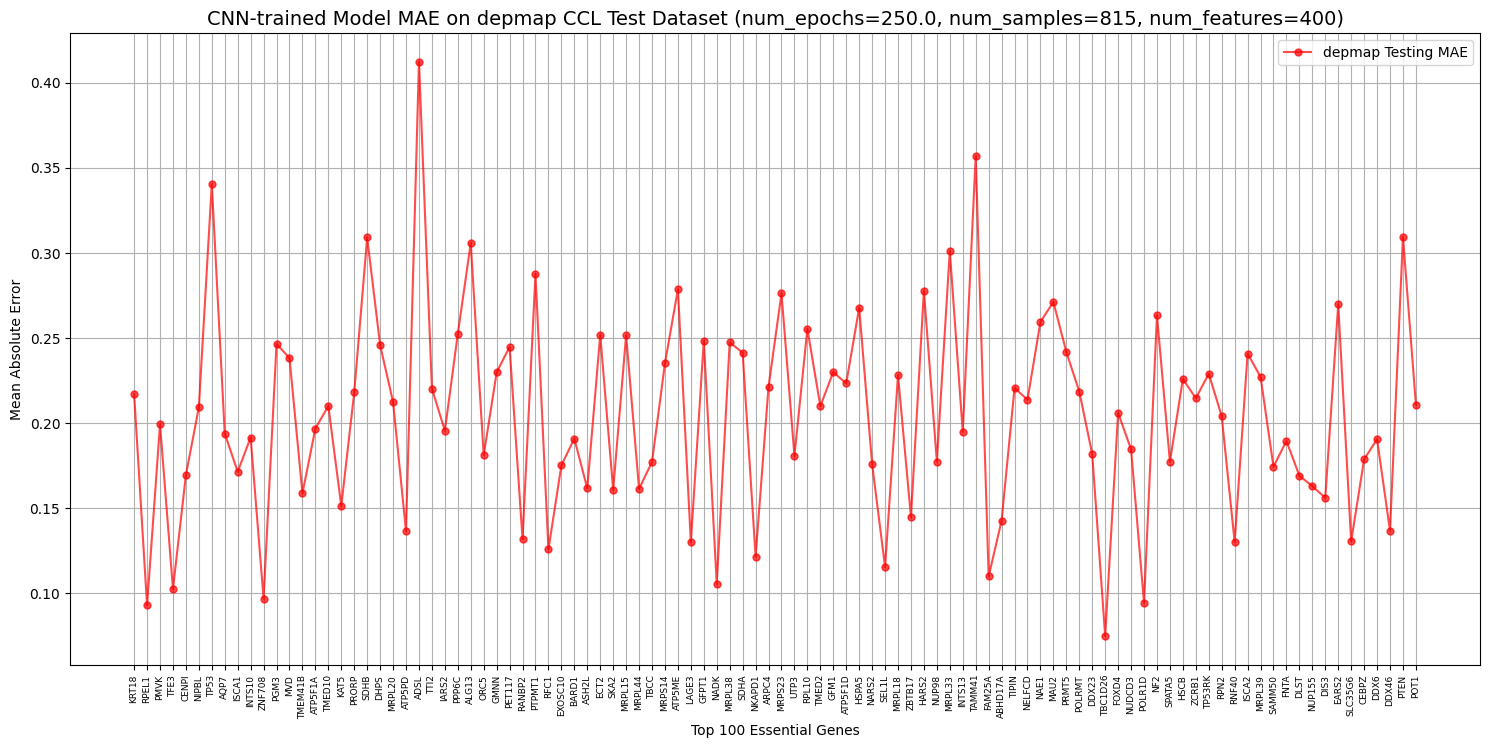

Average MAE for predicted gene effect scores on testing subset of CCLs: 0.2046


In [28]:
pred_MAE = CNNFuncs.PredGeneMAE(Y_test, test_predictions, top100_essential_genes)

CNNFuncs.LinePlot(pred_MAE, 
            {"MAE": "red"}, 
            axes_labels=["Top 100 Essential Genes", 
                         "Mean Absolute Error"], 
            main_title="CNN-trained Model MAE on {0} CCL Test Dataset (num_epochs={1}, num_samples={3}, num_features={2})".format(model_mode, num_epoch, X_train.shape[1], X_train.shape[0]),
            legend_titles={"MAE": "{0} Testing MAE".format(model_mode)})

print("Average MAE for predicted gene effect scores on testing subset of CCLs: {0:.4}".format(pred_MAE["MAE"].mean()))

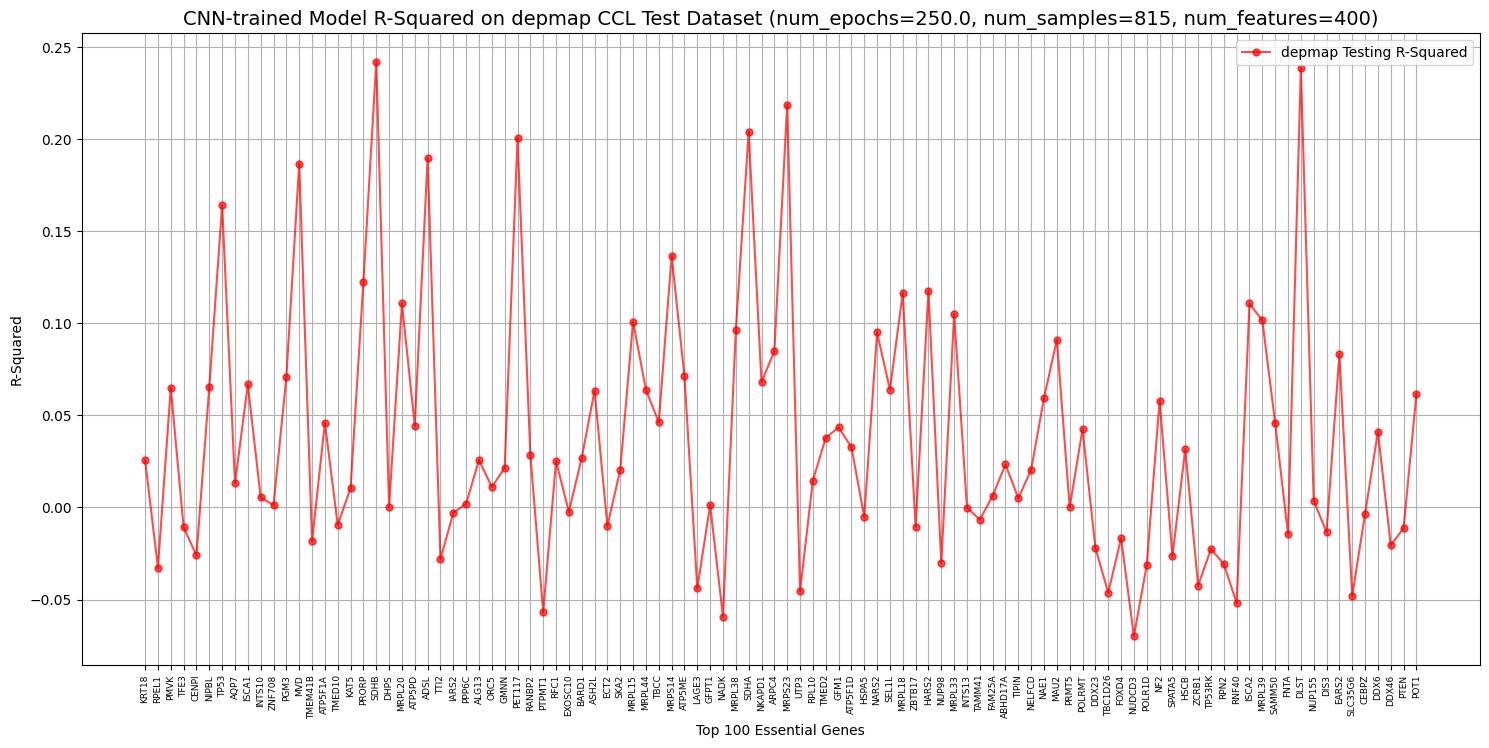

Average R-Squared for predicted gene effect scores on testing subset of CCLs: 0.03725


In [29]:
pred_RSquared = CNNFuncs.PredGeneRSquared(Y_test, test_predictions, top100_essential_genes)

CNNFuncs.LinePlot(pred_RSquared, 
            {"R-Squared": "red"}, 
            axes_labels=["Top 100 Essential Genes", 
                         "R-Squared"], 
            main_title="CNN-trained Model R-Squared on {0} CCL Test Dataset (num_epochs={1}, num_samples={3}, num_features={2})".format(model_mode, num_epoch, X_train.shape[1], X_train.shape[0]),
            legend_titles={"R-Squared": "{0} Testing R-Squared".format(model_mode)})

print("Average R-Squared for predicted gene effect scores on testing subset of CCLs: {0:.4}".format(pred_RSquared["R-Squared"].mean()))

## Model Mode tRCC dataset

In [30]:
tRCC_predictions = pd.DataFrame(model.predict(tRCC_gene_exp), columns=tRCC_gene_effect.columns, index=tRCC_gene_effect.index)

1/1 [==============================] - 0s 9ms/step


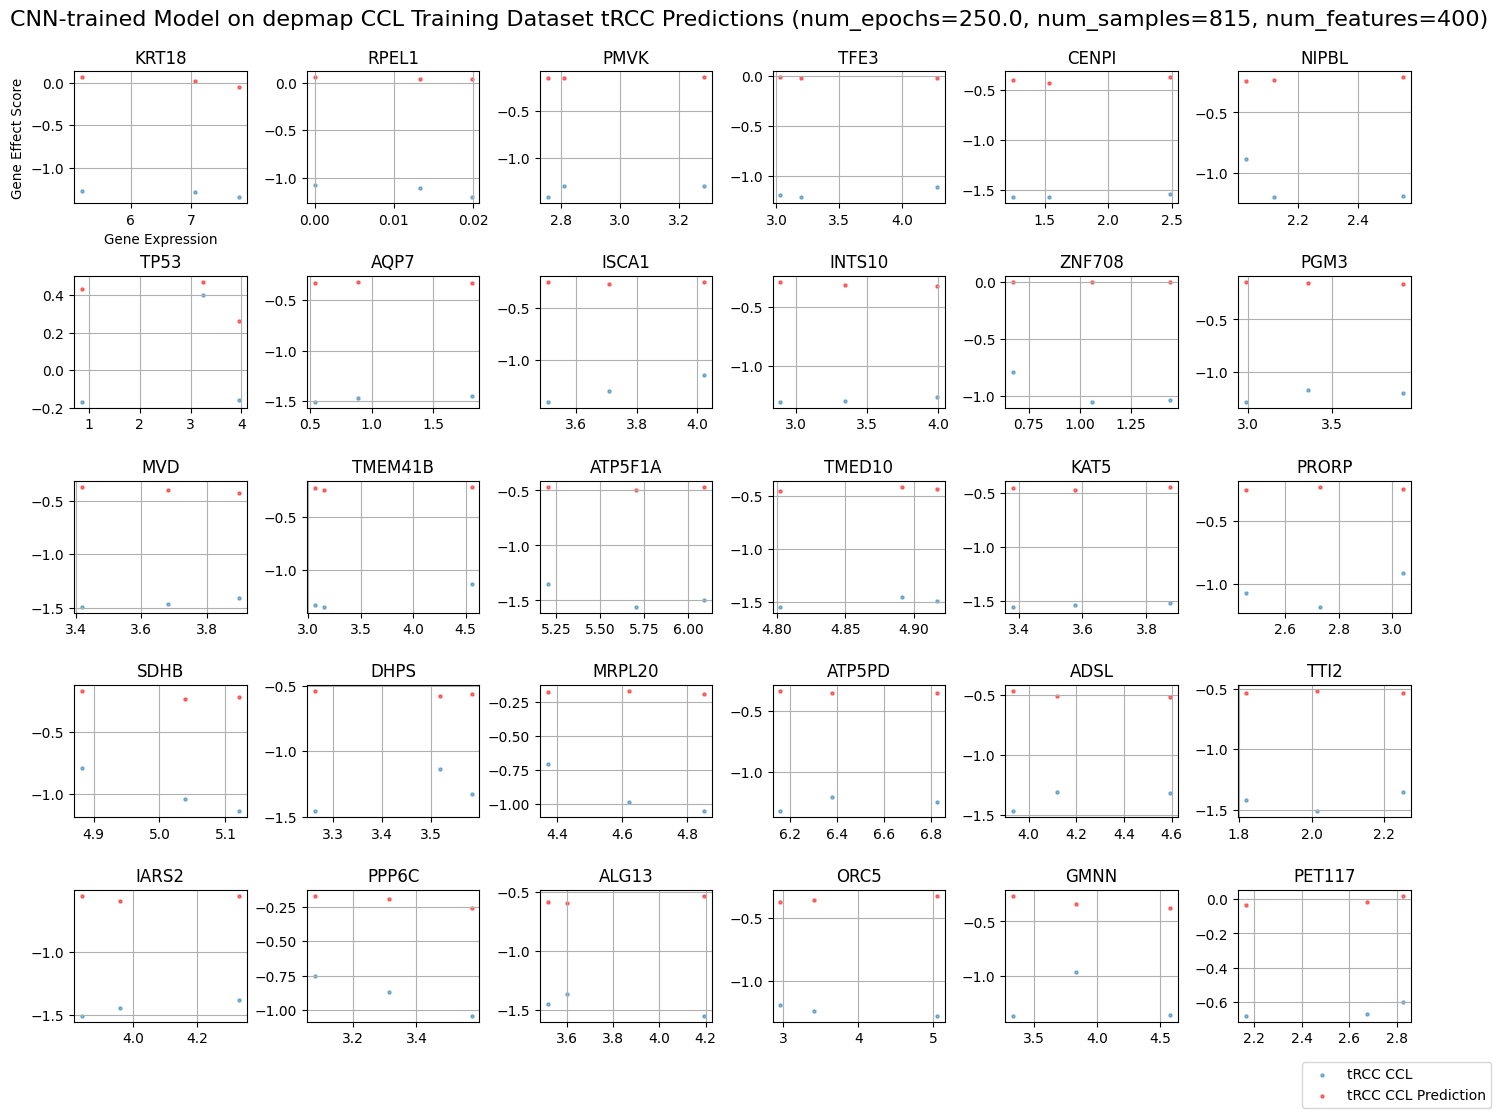

In [31]:
CNNFuncs.GeneRelMiniPlot(tRCC_gene_exp, tRCC_gene_effect, top100_essential_genes[:30].to_list(),
                         rel2_X=tRCC_gene_exp,
                         rel2_Y=tRCC_predictions,
                         main_title="CNN-trained Model on {0} CCL Training Dataset tRCC Predictions (num_epochs={1}, num_samples={3}, num_features={2})".format(model_mode, num_epoch, X_train.shape[1], X_train.shape[0]),
                         axes_labels=["Gene Expression", "Gene Effect Score"],
                         axis_label_fontsize=9.75,
                         legend_titles={"rel1": "tRCC CCL", "rel2": "tRCC CCL Prediction"},
                                        sizeProps=[0.925, 0.08, 0.99, 0],
                                        wspace=0.35,
                                        hspace=0.55)

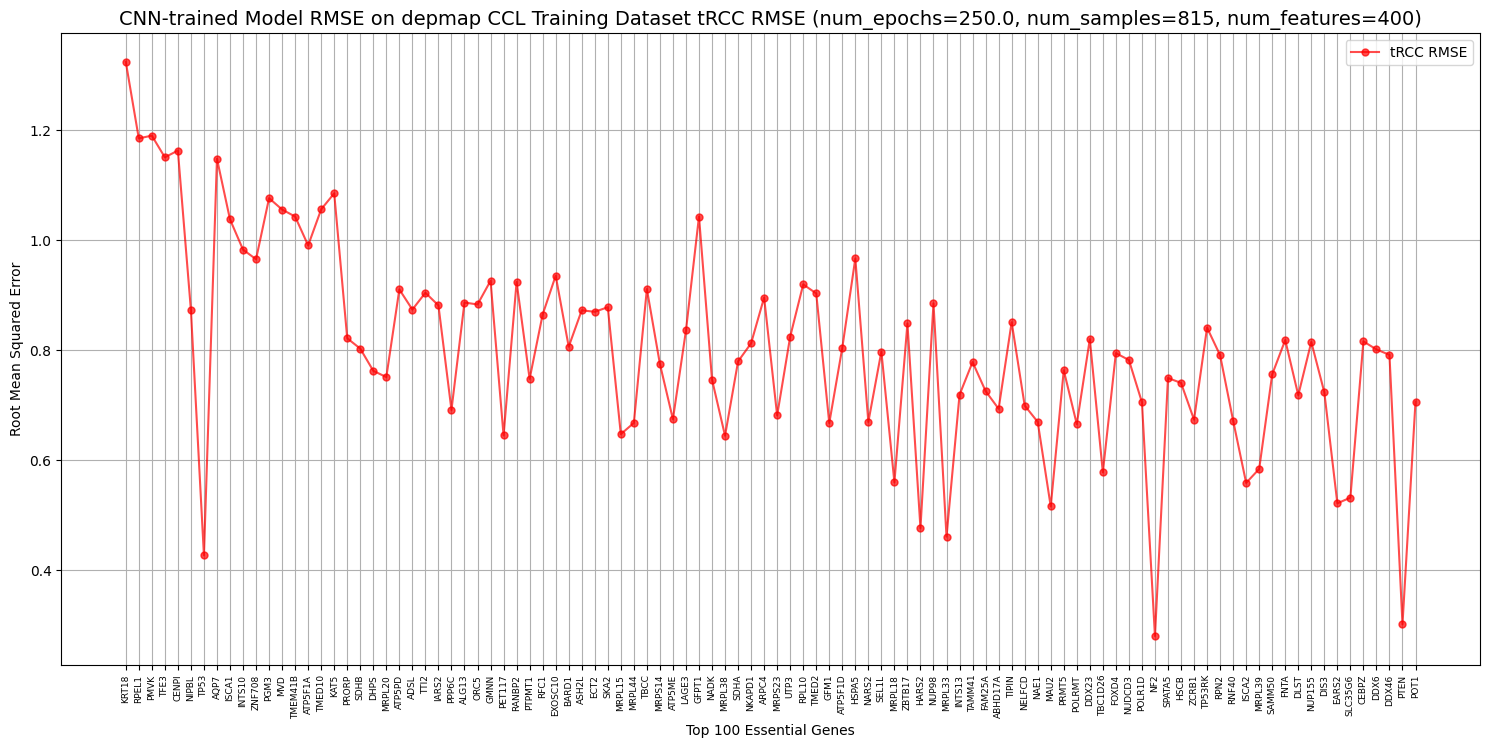

Average RMSE for predicted gene effect scores on tRCC CCLs: 0.8024


In [32]:
pred_RMSE = CNNFuncs.PredGeneRMSE(tRCC_gene_effect, tRCC_predictions, top100_essential_genes)

CNNFuncs.LinePlot(pred_RMSE, 
            {"RMSE": "red"}, 
            axes_labels=["Top 100 Essential Genes", 
                         "Root Mean Squared Error"], 
            main_title="CNN-trained Model RMSE on {0} CCL Training Dataset tRCC RMSE (num_epochs={1}, num_samples={3}, num_features={2})".format(model_mode, num_epoch, X_train.shape[1], X_train.shape[0]),
            legend_titles={"RMSE": "tRCC RMSE"})

print("Average RMSE for predicted gene effect scores on tRCC CCLs: {0:.4}".format(pred_RMSE["RMSE"].mean()))

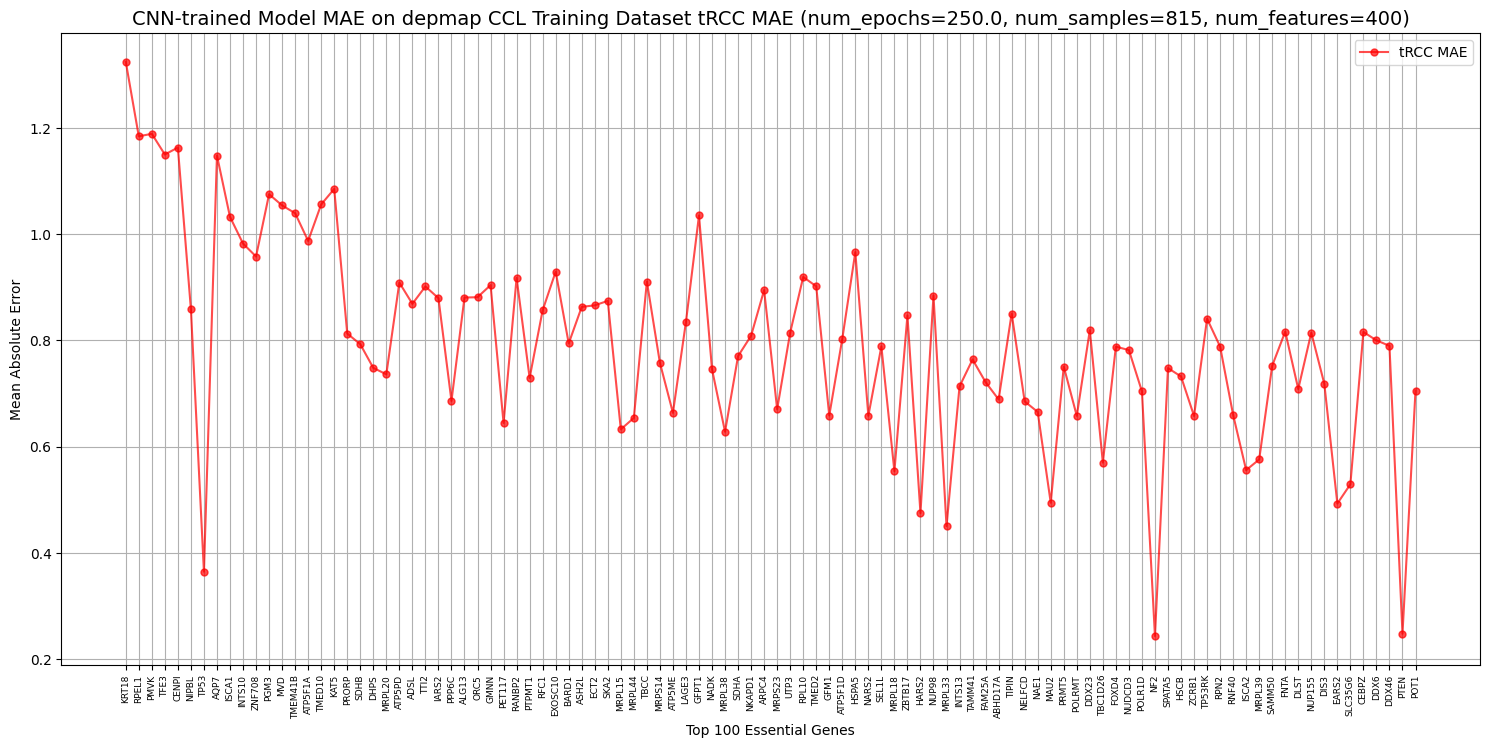

Average MAE for predicted gene effect scores on tRCC CCLs: 0.7951


In [33]:
pred_MAE = CNNFuncs.PredGeneMAE(tRCC_gene_effect, tRCC_predictions, top100_essential_genes)

CNNFuncs.LinePlot(pred_MAE, 
            {"MAE": "red"}, 
            axes_labels=["Top 100 Essential Genes", 
                         "Mean Absolute Error"], 
            main_title="CNN-trained Model MAE on {0} CCL Training Dataset tRCC MAE (num_epochs={1}, num_samples={3}, num_features={2})".format(model_mode, num_epoch, X_train.shape[1], X_train.shape[0]),
            legend_titles={"MAE": "tRCC MAE"})

print("Average MAE for predicted gene effect scores on tRCC CCLs: {0:.4}".format(pred_MAE["MAE"].mean()))

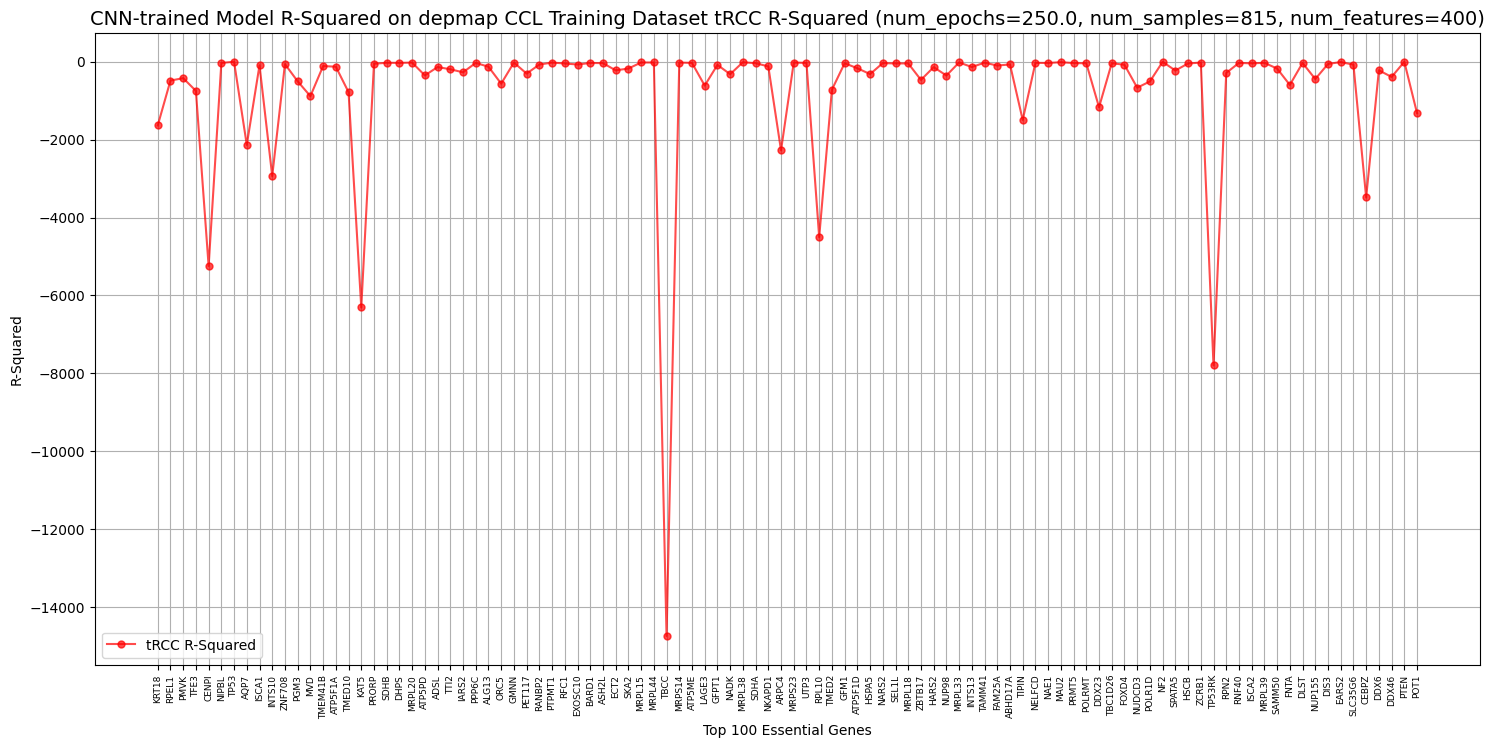

Average R-Squared for predicted gene effect scores on tRCC CCLs: -703.7


In [34]:
pred_RSquared = CNNFuncs.PredGeneRSquared(tRCC_gene_effect, tRCC_predictions, top100_essential_genes)

CNNFuncs.LinePlot(pred_RSquared, 
            {"R-Squared": "red"}, 
            axes_labels=["Top 100 Essential Genes", 
                         "R-Squared"], 
            main_title="CNN-trained Model R-Squared on {0} CCL Training Dataset tRCC R-Squared (num_epochs={1}, num_samples={3}, num_features={2})".format(model_mode, num_epoch, X_train.shape[1], X_train.shape[0]),
            legend_titles={"R-Squared": "tRCC R-Squared"})

print("Average R-Squared for predicted gene effect scores on tRCC CCLs: {0:.4}".format(pred_RSquared["R-Squared"].mean()))